In [1]:
mkdir -p ../src

In [2]:
%%writefile ../src/chaos.f90
! chaos encryption scheme
module chaos
  implicit none

  integer, parameter :: dp=kind(0.d0) ! double precision

contains
    subroutine rkm_receive(h,x,xp,N)
        implicit double precision (a-h,o-z)
        double precision, dimension (N) :: x,xdot1, xdot2, xdot3, xdot4, g
        hh=h*0.5;
        call deriv_receive(xdot1,x,xp,N)
        do i=1,N
            g(i)=x(i)+hh*xdot1(i);
        enddo
        call deriv_receive(xdot2,g,xp,N);
        do i=1,N
            g(i)=x(i)+hh*xdot2(i);
        enddo
        call deriv_receive(xdot3,g,xp,N);
        do i=1,N
            g(i)=x(i)+h*xdot3(i);
        enddo
        call deriv_receive(xdot4,g,xp,N);
        do i=1,N
            x(i)=x(i)+h*(xdot1(i)+2.0*(xdot2(i)+xdot3(i))+xdot4(i))/6.0;
        enddo
        return
    end
!*******************************************************************
    subroutine rkm_send(h,x,N)
        implicit double precision (a-h,o-z)
        double precision, dimension (N) :: x,xdot1, xdot2, xdot3, xdot4, g
        hh=h*0.5;
        call deriv_send(xdot1,x,N);
        do i=1,N
            g(i)=x(i)+hh*xdot1(i);
        enddo
        call deriv_send(xdot2,g,N);
        do i=1,3
            g(i)=x(i)+hh*xdot2(i);
        enddo
        call deriv_send(xdot3,g,N);
        do i=1,N
            g(i)=x(i)+h*xdot3(i);
        enddo
        call deriv_send(xdot4,g,N);
        do i=1,N
            x(i)=x(i)+h*(xdot1(i)+2.0*(xdot2(i)+xdot3(i))+xdot4(i))/6.0;
        enddo
        return
    end
!******************************************************************
    subroutine deriv_receive(xdot,x,xp,N)
        implicit double precision (a-h,o-z)
        double precision, dimension (N) :: x,xdot
        rho=25;
        sigma=10;
        beta=1.5;
        xdot(1)=sigma*(x(2)-x(1));
        xdot(2)=xp*rho-x(2)-xp*x(3);
        xdot(3)=xp*x(2)-beta*x(3);
        return
    end
!*********************************************************************
    subroutine deriv_send(xdot,x,N)
        implicit double precision (a-h,o-z)
        double precision, dimension (N) :: x,xdot 
        rho=25;
        sigma=10;
        beta=1.5;
        xdot(1)=sigma*(x(2)-x(1));
        xdot(2)=x(1)*rho-x(2)-x(1)*x(3);
        xdot(3)=x(1)*x(2)-beta*x(3);
        return
    end
!***********************************************************************
end module chaos

Overwriting ../src/chaos.f90


In [7]:
%%writefile ../src/main.f90
program chaos_commn
parameter (N=3,nosdata=40000)
implicit double precision (a-h,o-z)
double precision, dimension(nosdata) :: xt,xr,signal,recovered,encryptedx
double precision, dimension (N):: xold
tstep=0.0001;
ndrop=15000;
xold(1)=rand();
xold(2)=rand();
xold(3)=rand();
do i=1,ndrop
   call rkm_send(tstep,xold,N)
enddo
do i=1,nosdata
    call rkm_send(tstep,xold,N)
    xt(i)=xold(1);
enddo
do i=1,nosdata
   !signal(i)=rand()
   signal(i)=1.5*sin(0.01*float(i)) +1.0*sin(0.01*sqrt(2.0)*float(i))
enddo
do i=1,nosdata
   encryptedx(i)=signal(i)+xt(i);
enddo 
!renormscale(1)=minval(encryptedx,nosdata);
!renormscale(2)=maxval(encryptedx,nosdata);
!encryptedx=mynorm(encryptedx_pratik_speaker,normscale,numsample)';
!for i=1:numsample
!    encryptedx(i)=normscale(1)+(encryptedx_pratik_speaker(i)-renormscale(1))*(normscale(2)-normscale(1))/(renormscale(2)-renormscale(1));
!end    
!%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
xold(1)=rand();
xold(2)=rand();
xold(3)=rand();
do i=1,ndrop
   call rkm_send(tstep,xold,N);
enddo 
do  i=1, nosdata
    call rkm_receive(tstep,xold,encryptedx(i),N);
    xr(i)=xold(1);
enddo
do i=1,nosdata
   recovered(i)=(encryptedx(i)-xr(i));
enddo
open (3,file="signal_recovered.dat")
do i=1,nosdata
   write(3,*)signal(i), recovered(i)
enddo
close(3)
end

Overwriting ../src/main.f90


In [4]:
%%bash
pushd ../src
gfortran -o chaos chaos.f90 main.f90
./chaos
popd


~/2015/crypto-chaotic/src ~/2015/crypto-chaotic/doc
~/2015/crypto-chaotic/doc


Populating the interactive namespace from numpy and matplotlib


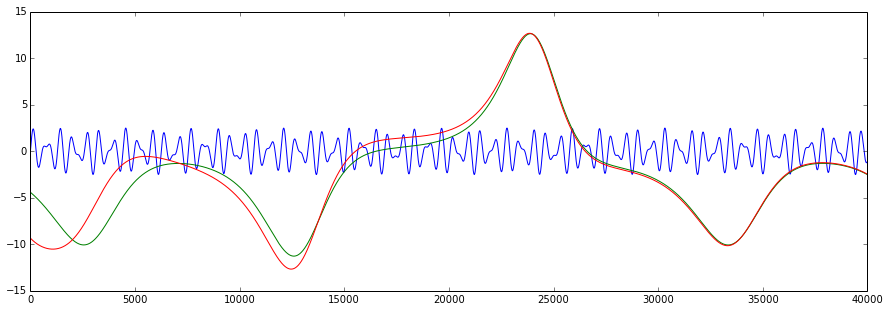

In [8]:
%pylab inline
from matplotlib import rcParams
import matplotlib.pyplot as plt

dataMatrix1 = genfromtxt('../src/signal_recovered.dat')

y1 = dataMatrix1[:,0]
y2 = dataMatrix1[:,1]
y3 = dataMatrix1[:,2]
x = range(len(y1))

plt.figure(figsize=(15, 5))

plt.plot(x,y1)
plt.plot(x,y2)
plt.plot(x,y3)
plt.show()